<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/tda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topological Data Analysis**

https://javier-marin.medium.com/topological-data-analisys-part-2-926d523cd5db

#### <font color="blue">***Quantum TDA Test Run***

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.special import comb
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigs
from itertools import product
import statistics

import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
def quantum_cost(n, E, r, gap, k, betti_k_minus_one):
  """Calculates Toffoli count given parameters to the TDA algorithm.
  Args:
    n: number of vertices
    E: number of edges
    gap: difference between lowest and second lowest eigenvalue of the k-th
      order combinatorial Laplacian
    k: order of Betti number
    betti_k_minus_one: Betti number of order k-1

  Returns:
    Toffoli count
  """
  return n * E * np.sqrt(comb(n, k) / betti_k_minus_one) / (r * gap)

In [ ]:
def get_cliques_of_size(G, k):
  """Gets cliques of a graph.
  Args:
    G: `nx.Graph` problem graph
    k: order of Betti number being estimated

  Returns:
    A 3-tuple of `list`, respectively the cliques of size k-1, k and k+1
  """
  all_cliques = list(nx.enumerate_all_cliques(G))
  lower_cliques = list(filter(lambda x: len(x) == k-1, all_cliques))
  cliques = list(filter(lambda x: len(x) == k, all_cliques))
  upper_cliques = list(filter(lambda x: len(x) == k+1, all_cliques))

  return lower_cliques, cliques, upper_cliques

In [ ]:
def is_upper_clique(clique, upper_clique):
  """Decides if two cliques are adjacent. They have to have difference 1 in size.
  Args:
    clique: the smaller clique
    upper_clique: the larger clique

  Returns:
    Whether upper_clique is clique appended by one number
  """
  return (len(upper_clique) - len(clique) == 1) and (len(set(upper_clique) - set(clique)) == 1)

In [ ]:
def get_number_of_upper_cliques(clique, upper_cliques):
  """Gets number of upper cliques a clique has.
  Args:
    clique: the clique
    upper_cliques: a list with cliques of size 1 larger than clique

  Returns:
    The number of cliques in upper_cliques that are upper to clique.
  """
  total = 0
  for upper_clique in upper_cliques:
    if is_upper_clique(clique, upper_clique):
      total +=1

  return total

In [ ]:
def lower_not_upper_similarity(clique1, clique2, lower_cliques, upper_cliques):
  """Calculates off-diagonal entries of combinatorial Laplacian.

  Args:
    clique1: k-clique indexing the row
    clique2: k-clique indexing the column
    lower_cliques: `list` of (k-1)-cliques
    upper_cliques: `list` of (k+1)-cliques

  Returns:
    The off-diagonal entry at coordinate (clique1, clique2).
  """
  # have common upper?
  for upper_clique in upper_cliques:
    if is_upper_clique(clique1, upper_clique) and is_upper_clique(clique2, upper_clique):
      return 0

  # don't have common upper
  # have common lower?

  # NEW CODE
  # clique1 and clique2 are lower similar if and only if they differ on exactly one vertex
  # Sign is given by the parity of the number of different elements: odd --> +1, even --> -1
  if len(set(clique1).difference(set(clique2)))==1:
    return 2 * (np.count_nonzero(np.array(clique1) - np.array(clique2)) % 2) - 1

  # OLD CODE
  '''
  for lower_clique in lower_cliques:
    if is_upper_clique(lower_clique, clique1) and is_upper_clique(lower_clique, clique2):
     # have a common lower. Need to find similarity.

     diff_inds = []
     diff_elems1 = list(set(clique1) - set(clique2))
     diff_inds.append(clique1.index(diff_elems1[0]))

     diff_elems2 = list(set(clique2) - set(clique1))
     diff_inds.append(clique2.index(diff_elems2[0]))

     if len(diff_inds) == 1:
       sign = 0
     else:
       sign = ((diff_inds[1] - diff_inds[0]) % 2)

     return (-1) ** sign
  '''

  # don't have common lower
  return 0

In [ ]:
### THIS IS ACTUALLY COMPUTING THE ORDER (k-1)
# returns the combinatorial Laplacian of order k of a graph
def get_laplacian(G, k):
  """Computes the k-th order Laplacian of a graph G using theorem 3.3.4 in
  http://www2.stat.duke.edu/~sayan/forkate/CombinatorialLaplacians.pdf.

  Args:
    G: `nx.Graph` input graph
    k: order of Betti number to be estimated

  Returns:
    The matrix of such combinatorial Laplacian.
  """
  # standard Laplacian
  if k==0:
    return nx.laplacian_matrix(G)

  #k += 1
  lower_cliques, cliques, upper_cliques = get_cliques_of_size(G, k)

  n_cliques = len(cliques)
  laplacian = np.zeros((n_cliques, n_cliques))
  for (row, clique_row) in enumerate(cliques):
    for (column, clique_column) in enumerate(cliques):
      # diagonal
      if row == column:
        #laplacian[row][column] = k + 1 + get_number_of_upper_cliques(clique_row, upper_cliques)
        laplacian[row][column] = k + get_number_of_upper_cliques(clique_row, upper_cliques)

      # off-diagonals
      else:
        laplacian[row][column] = lower_not_upper_similarity(clique_row, clique_column, lower_cliques, upper_cliques)

  return laplacian

In [ ]:
def get_laplacian_spectrum(G, k):
  """Computes the eigenvalue spectrum of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    `list` of eigenvalues
  """
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  eigvals = np.sort(eigvals)

  return eigvals

In [ ]:
# calculates combinatorial laplacian gap of a graph G at order k as well as the
# number of zero eigenvalues
def get_laplacian_info(G, k):
  """Computes the difference between the second lowest and lowest eigenvalues
  of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    The gap of the Laplacian and the number of zero eigenvalues.
  """
  '''
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  '''
  eigvals = get_laplacian_spectrum(G, k)
  eigvals = list(map(lambda x: 0 if np.abs(x) < 0.000000000001 else x, list(eigvals)))

  betti_number = eigvals.count(0)

  eigvals = np.unique(eigvals)

  return eigvals[1] - eigvals[0], betti_number

(k, n, sample) = (1, 10, 0)
(k, n, sample) = (1, 10, 1)
(k, n, sample) = (1, 10, 2)
(k, n, sample) = (1, 10, 3)
(k, n, sample) = (1, 10, 4)
(k, n, sample) = (1, 10, 5)
(k, n, sample) = (1, 10, 6)
(k, n, sample) = (1, 10, 7)
(k, n, sample) = (1, 10, 8)
(k, n, sample) = (1, 10, 9)
(k, n, sample) = (1, 10, 10)
(k, n, sample) = (1, 10, 11)
(k, n, sample) = (1, 10, 12)
(k, n, sample) = (1, 10, 13)
(k, n, sample) = (1, 10, 14)
(k, n, sample) = (1, 10, 15)
(k, n, sample) = (1, 10, 16)
(k, n, sample) = (1, 10, 17)
(k, n, sample) = (1, 10, 18)
(k, n, sample) = (1, 10, 19)
(k, n, sample) = (1, 10, 20)
(k, n, sample) = (1, 10, 21)
(k, n, sample) = (1, 10, 22)
(k, n, sample) = (1, 10, 23)
(k, n, sample) = (1, 10, 24)
(k, n, sample) = (1, 10, 25)
(k, n, sample) = (1, 10, 26)
(k, n, sample) = (1, 10, 27)
(k, n, sample) = (1, 10, 28)
(k, n, sample) = (1, 10, 29)
(k, n, sample) = (1, 10, 30)
(k, n, sample) = (1, 10, 31)
(k, n, sample) = (1, 10, 32)
(k, n, sample) = (1, 10, 33)
(k, n, sample) = (1, 10,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


(k, n, sample) = (1, 10, 136)
(k, n, sample) = (1, 10, 137)
(k, n, sample) = (1, 10, 138)
(k, n, sample) = (1, 10, 139)
(k, n, sample) = (1, 10, 140)
(k, n, sample) = (1, 10, 141)
(k, n, sample) = (1, 10, 142)
(k, n, sample) = (1, 10, 143)
(k, n, sample) = (1, 10, 144)
(k, n, sample) = (1, 10, 145)
(k, n, sample) = (1, 10, 146)
(k, n, sample) = (1, 10, 147)
(k, n, sample) = (1, 10, 148)
(k, n, sample) = (1, 10, 149)
(k, n, sample) = (1, 10, 150)
(k, n, sample) = (1, 10, 151)
(k, n, sample) = (1, 10, 152)
(k, n, sample) = (1, 10, 153)
(k, n, sample) = (1, 10, 154)
(k, n, sample) = (1, 10, 155)
(k, n, sample) = (1, 10, 156)
(k, n, sample) = (1, 10, 157)
(k, n, sample) = (1, 10, 158)
(k, n, sample) = (1, 10, 159)
(k, n, sample) = (1, 10, 160)
(k, n, sample) = (1, 10, 161)
(k, n, sample) = (1, 10, 162)
(k, n, sample) = (1, 10, 163)
(k, n, sample) = (1, 10, 164)
(k, n, sample) = (1, 10, 165)
(k, n, sample) = (1, 10, 166)
(k, n, sample) = (1, 10, 167)
(k, n, sample) = (1, 10, 168)
(k, n, sam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  



(k, n, sample) = (1, 10, 1442)
(k, n, sample) = (1, 10, 1443)
(k, n, sample) = (1, 10, 1444)
(k, n, sample) = (1, 10, 1445)
(k, n, sample) = (1, 10, 1446)
(k, n, sample) = (1, 10, 1447)
(k, n, sample) = (1, 10, 1448)
(k, n, sample) = (1, 10, 1449)
(k, n, sample) = (1, 10, 1450)
(k, n, sample) = (1, 10, 1451)
(k, n, sample) = (1, 10, 1452)
(k, n, sample) = (1, 10, 1453)
(k, n, sample) = (1, 10, 1454)
(k, n, sample) = (1, 10, 1455)
(k, n, sample) = (1, 10, 1456)
(k, n, sample) = (1, 10, 1457)
(k, n, sample) = (1, 10, 1458)
(k, n, sample) = (1, 10, 1459)
(k, n, sample) = (1, 10, 1460)
(k, n, sample) = (1, 10, 1461)
(k, n, sample) = (1, 10, 1462)
(k, n, sample) = (1, 10, 1463)
(k, n, sample) = (1, 10, 1464)
(k, n, sample) = (1, 10, 1465)
(k, n, sample) = (1, 10, 1466)
(k, n, sample) = (1, 10, 1467)
(k, n, sample) = (1, 10, 1468)
(k, n, sample) = (1, 10, 1469)
(k, n, sample) = (1, 10, 1470)
(k, n, sample) = (1, 10, 1471)
(k, n, sample) = (1, 10, 1472)
(k, n, sample) = (1, 10, 1473)
(k, n, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in cdouble_scalars


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
(k, n, sample) = (2, 20, 1000)
(k, n, sample) = (2, 20, 1001)
(k, n, sample) = (2, 20, 1002)
(k, n, sample) = (2, 20, 1003)
(k, n, sample) = (2, 20, 1004)
(k, n, sample) = (2, 20, 1005)
(k, n, sample) = (2, 20, 1006)
(k, n, sample) = (2, 20, 1007)
(k, n, sample) = (2, 20, 1008)
(k, n, sample) = (2, 20, 1009)
(k, n, sample) = (2, 20, 1010)
(k, n, sample) = (2, 20, 1011)
(k, n, sample) = (2, 20, 1012)
(k, n, sample) = (2, 20, 1013)
(k, n, sample) = (2, 20, 1014)
(k, n, sample) = (2, 20, 1015)
(k, n, sample) = (2, 20, 1016)
(k, n, sample) = (2, 20, 1017)
(k, n, sample) = (2, 20, 1018)
(k, n, sample) = (2, 20, 1019)
(k, n, sample) = (2, 20, 1020)
(k, n, sample) = (2, 20, 1021)
(k, n, sample) = (2, 20, 1022)
(k, n, sample) = (2, 20, 1023)
(k, n, sample) = (2, 20, 1024)
(k, n, sample) = (2, 20, 1025)
(k, n, sample) = (2, 20, 1026)
(k, n, sample) = (2, 20, 1027)
(k, n, sample) = (2, 20, 1028)
(k, n, sample) = (2, 20, 1029)
(k,

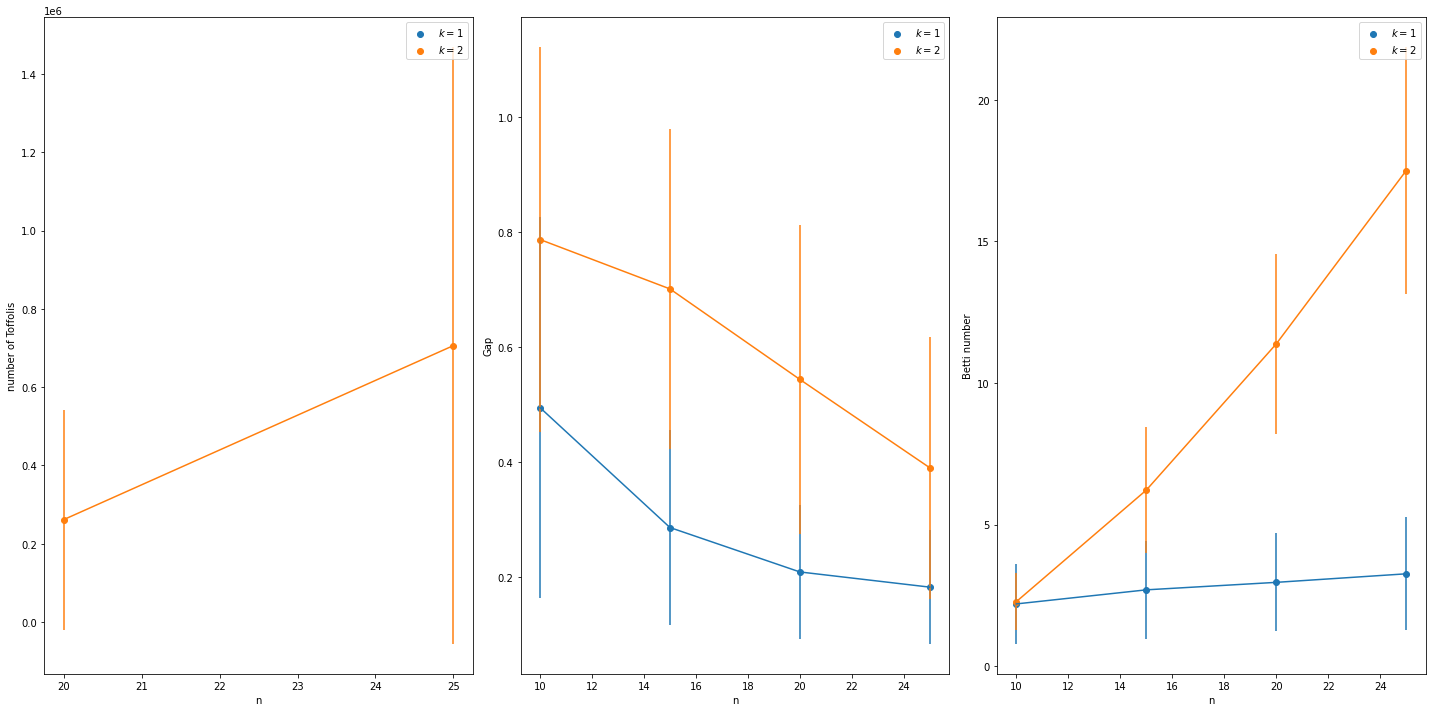

In [ ]:
#@title
# old code with non log data

def generate_plots(ns, ks):
  """Generates plots of combinatorial laplacian gap, betti number and number
  of Toffolis for a combination of n's and k's.

  Args:
    ns: `list` of `int` of n's
    ks: `list` of `int` of n's
  """
  n_samples = 3000
  gaps = [[] for _ in range(len(ks))]
  gap_stds = [[] for _ in range(len(ks))]
  bettis = [[] for _ in range(len(ks))]
  betti_stds = [[] for _ in range(len(ks))]
  costs = [[] for _ in range(len(ks))]
  cost_stds = [[] for _ in range(len(ks))]

  for k_ind, k in enumerate(ks):
    for n in ns:
      p = n ** (- (2 * k + 1)/float(2 * k * (k + 1)))
      betti_samples = []
      cost_samples = []
      gap_samples = []
      for ind in range(n_samples):
        print(f'(k, n, sample) = ({k}, {n}, {ind})')
        G = nx.erdos_renyi_graph(n, p)
        gap, betti_number = get_laplacian_info(G, k)
        betti_samples.append(betti_number)
        gap_samples.append(gap)
        cost_samples.append(quantum_cost(n, G.number_of_edges(), 0.05, gap, k, betti_number))

      cost_avg = sum(cost_samples) / n_samples
      betti_avg = sum(betti_samples) / float(n_samples)
      gap_avg = sum(gap_samples) / n_samples

      cost_std = statistics.stdev(np.real(cost_samples))
      betti_std = statistics.stdev(np.real(betti_samples))
      gap_std = statistics.stdev(np.real(gap_samples))

      costs[k_ind].append(cost_avg)
      bettis[k_ind].append(betti_avg)
      gaps[k_ind].append(gap_avg)

      cost_stds[k_ind].append(cost_std)
      betti_stds[k_ind].append(betti_std)
      gap_stds[k_ind].append(gap_std)

  fig = plt.figure(figsize=(20, 10))

  #fig.subplots_adjust(hspace=0.4, wspace=0.4)

  ax_costs = fig.add_subplot(1,3,1)
  for k_ind, k in enumerate(ks):
    ax_costs.scatter(ns, costs[k_ind])
    ax_costs.set_xlabel('n')
    ax_costs.set_ylabel('number of Toffolis')
    ax_costs.errorbar(ns, costs[k_ind], yerr=cost_stds[k_ind])
  ax_costs.legend([f'$k = {k}$' for k in ks])

  ax_gaps = fig.add_subplot(1,3,2)
  for k_ind, k in enumerate(ks):
    ax_gaps.scatter(ns, gaps[k_ind])
    ax_gaps.set_xlabel('n')
    ax_gaps.set_ylabel('Gap')
    ax_gaps.errorbar(ns, gaps[k_ind], yerr=gap_stds[k_ind])
  ax_gaps.legend([f'$k = {k}$' for k in ks])

  ax_bettis = fig.add_subplot(1,3,3)
  for k_ind, k in enumerate(ks):
    ax_bettis.scatter(ns, bettis[k_ind])
    ax_bettis.set_xlabel('n')
    ax_bettis.set_ylabel('Betti number')
    ax_bettis.errorbar(ns, bettis[k_ind], yerr=betti_stds[k_ind])
  ax_bettis.legend([f'$k = {k}$' for k in ks])

  plt.tight_layout()
  plt.subplots_adjust()
  plt.show()

generate_plots([10, 15, 20, 25], [1,2])

**Try to plot things on a log / log plot so that we can try to infer the polynomial order of the gap scaling:**

In [ ]:
def generate_plots(ns, ks):
  """Generates plots of combinatorial laplacian gap, betti number and number
  of Toffolis for a combination of n's and k's.

  Args:
    ns: `list` of `int` of n's
    ks: `list` of `int` of n's
  """
  n_samples = 100
  gaps = [[] for _ in range(len(ks))]
  gap_stds = [[] for _ in range(len(ks))]
  bettis = [[] for _ in range(len(ks))]
  betti_stds = [[] for _ in range(len(ks))]
  costs = [[] for _ in range(len(ks))]
  cost_stds = [[] for _ in range(len(ks))]

  for k_ind, k in enumerate(ks):
    for n in ns:
      p = n ** (- (2 * k + 1)/float(2 * k * (k + 1)))
      betti_samples = []
      cost_samples = []
      gap_samples = []
      for ind in range(n_samples):
        print(f'(k, n, sample) = ({k}, {n}, {ind})')
        G = nx.erdos_renyi_graph(n, p)
        gap, betti_number = get_laplacian_info(G, k)
        betti_samples.append(betti_number)
        gap_samples.append(gap)
        cost_samples.append(quantum_cost(n, G.number_of_edges(), 0.05, gap, k, betti_number))

      cost_avg = sum(cost_samples) / n_samples
      betti_avg = sum(betti_samples) / float(n_samples)
      gap_avg = sum(gap_samples) / n_samples

      cost_std = statistics.stdev(np.real(cost_samples))
      betti_std = statistics.stdev(np.real(betti_samples))
      gap_std = statistics.stdev(np.real(gap_samples))

      costs[k_ind].append(cost_avg)
      bettis[k_ind].append(betti_avg)
      gaps[k_ind].append(gap_avg)

      cost_stds[k_ind].append(cost_std)
      betti_stds[k_ind].append(betti_std)
      gap_stds[k_ind].append(gap_std)

  fig = plt.figure(figsize=(20, 10))

  #fig.subplots_adjust(hspace=0.4, wspace=0.4)

  ax_costs = fig.add_subplot(1,3,1)
  for k_ind, k in enumerate(ks):
    ax_costs.scatter(np.log(ns), np.log(costs[k_ind]))
    ax_costs.set_xlabel('log of n')
    ax_costs.set_ylabel('log of number of Toffolis')
    ax_costs.errorbar(np.log(ns), np.log(costs[k_ind]), yerr=np.log(cost_stds[k_ind]))
  ax_costs.legend([f'$k = {k}$' for k in ks])

  ax_gaps = fig.add_subplot(1,3,2)
  for k_ind, k in enumerate(ks):
    ax_gaps.scatter(np.log(ns), np.log(gaps[k_ind]))
    ax_gaps.set_xlabel('log of n')
    ax_gaps.set_ylabel('log of Gap')
    ax_gaps.errorbar(np.log(ns), np.log(gaps[k_ind]), yerr=np.log(gap_stds[k_ind]))
  ax_gaps.legend([f'$k = {k}$' for k in ks])

  ax_bettis = fig.add_subplot(1,3,3)
  for k_ind, k in enumerate(ks):
    ax_bettis.scatter(np.log(ns), np.log(bettis[k_ind]))
    ax_bettis.set_xlabel('log of n')
    ax_bettis.set_ylabel('log of Betti number')
    ax_bettis.errorbar(np.log(ns), np.log(bettis[k_ind]), yerr=np.log(betti_stds[k_ind]))
  ax_bettis.legend([f'$k = {k}$' for k in ks])

  plt.tight_layout()
  plt.subplots_adjust()
  plt.show()

generate_plots([25], [8])

(k, n, sample) = (8, 25, 0)
(k, n, sample) = (8, 25, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


IndexError: ignored

#### <font color="blue">***CPU Performance Test Run***

##### *Simple Example*

In [ ]:
import math
import sympy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from psutil import *
cpu_count()

2

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes

    CPU Performance in sec
5                 0.000021
10                0.000044
15                0.000499
20                0.004968
25                0.051973


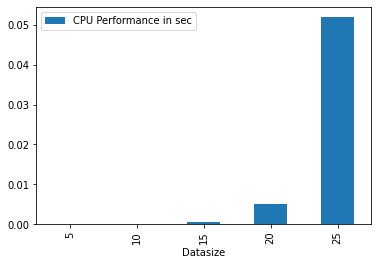

In [ ]:
# Compute and display complexity of Fibonacci

import time

def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)


# My input data for the function
my_tuple = 5,10,15,20,25

# Define empty bucket
rows_list = []

for n in my_tuple:

    # Begin tracking CPU time
    st = time.process_time(),

    # Run algorithms
    result = fibonacci(n),

    # Finish tracking CPU time
    et = time.process_time(),

    # Calculate performance (end - begin)
    performance = [x - y for x, y in zip(list(et), list(st))]

    # Collect results in a list
    rows_list.append(performance)

# Write results in a table
df = pd.DataFrame(rows_list, index=my_tuple, columns=['CPU Performance in sec'])
print(df)

# Visualize results in a graph
df = df.reset_index().rename(columns={"index": "Datasize"})
df.plot(x ='Datasize', y='CPU Performance in sec', kind = 'bar')

##### *Code for Generating plots of combinatorial laplacian gap, betti number and number of Toffolis for a combination of n's and k's*

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.special import comb
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigs
from itertools import product
import statistics

import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
def quantum_cost(n, E, r, gap, k, betti_k_minus_one):
  """Calculates Toffoli count given parameters to the TDA algorithm.
  Args:
    n: number of vertices
    E: number of edges
    gap: difference between lowest and second lowest eigenvalue of the k-th
      order combinatorial Laplacian
    k: order of Betti number
    betti_k_minus_one: Betti number of order k-1

  Returns:
    Toffoli count
  """
  return n * E * np.sqrt(comb(n, k) / betti_k_minus_one) / (r * gap)

In [ ]:
def get_cliques_of_size(G, k):
  """Gets cliques of a graph.
  Args:
    G: `nx.Graph` problem graph
    k: order of Betti number being estimated

  Returns:
    A 3-tuple of `list`, respectively the cliques of size k-1, k and k+1
  """
  all_cliques = list(nx.enumerate_all_cliques(G))
  lower_cliques = list(filter(lambda x: len(x) == k-1, all_cliques))
  cliques = list(filter(lambda x: len(x) == k, all_cliques))
  upper_cliques = list(filter(lambda x: len(x) == k+1, all_cliques))

  return lower_cliques, cliques, upper_cliques

In [ ]:
def is_upper_clique(clique, upper_clique):
  """Decides if two cliques are adjacent. They have to have difference 1 in size.
  Args:
    clique: the smaller clique
    upper_clique: the larger clique

  Returns:
    Whether upper_clique is clique appended by one number
  """
  return (len(upper_clique) - len(clique) == 1) and (len(set(upper_clique) - set(clique)) == 1)

In [ ]:
def get_number_of_upper_cliques(clique, upper_cliques):
  """Gets number of upper cliques a clique has.
  Args:
    clique: the clique
    upper_cliques: a list with cliques of size 1 larger than clique

  Returns:
    The number of cliques in upper_cliques that are upper to clique.
  """
  total = 0
  for upper_clique in upper_cliques:
    if is_upper_clique(clique, upper_clique):
      total +=1

  return total

In [ ]:
def lower_not_upper_similarity(clique1, clique2, lower_cliques, upper_cliques):
  """Calculates off-diagonal entries of combinatorial Laplacian.

  Args:
    clique1: k-clique indexing the row
    clique2: k-clique indexing the column
    lower_cliques: `list` of (k-1)-cliques
    upper_cliques: `list` of (k+1)-cliques

  Returns:
    The off-diagonal entry at coordinate (clique1, clique2).
  """
  # have common upper?
  for upper_clique in upper_cliques:
    if is_upper_clique(clique1, upper_clique) and is_upper_clique(clique2, upper_clique):
      return 0

  # don't have common upper
  # have common lower?

  # NEW CODE
  # clique1 and clique2 are lower similar if and only if they differ on exactly one vertex
  # Sign is given by the parity of the number of different elements: odd --> +1, even --> -1
  if len(set(clique1).difference(set(clique2)))==1:
    return 2 * (np.count_nonzero(np.array(clique1) - np.array(clique2)) % 2) - 1

  # OLD CODE
  '''
  for lower_clique in lower_cliques:
    if is_upper_clique(lower_clique, clique1) and is_upper_clique(lower_clique, clique2):
     # have a common lower. Need to find similarity.

     diff_inds = []
     diff_elems1 = list(set(clique1) - set(clique2))
     diff_inds.append(clique1.index(diff_elems1[0]))

     diff_elems2 = list(set(clique2) - set(clique1))
     diff_inds.append(clique2.index(diff_elems2[0]))

     if len(diff_inds) == 1:
       sign = 0
     else:
       sign = ((diff_inds[1] - diff_inds[0]) % 2)

     return (-1) ** sign
  '''

  # don't have common lower
  return 0

In [ ]:
### THIS IS ACTUALLY COMPUTING THE ORDER (k-1)
# returns the combinatorial Laplacian of order k of a graph
def get_laplacian(G, k):
  """Computes the k-th order Laplacian of a graph G using theorem 3.3.4 in
  http://www2.stat.duke.edu/~sayan/forkate/CombinatorialLaplacians.pdf.

  Args:
    G: `nx.Graph` input graph
    k: order of Betti number to be estimated

  Returns:
    The matrix of such combinatorial Laplacian.
  """
  # standard Laplacian
  if k==0:
    return nx.laplacian_matrix(G)

  #k += 1
  lower_cliques, cliques, upper_cliques = get_cliques_of_size(G, k)

  n_cliques = len(cliques)
  laplacian = np.zeros((n_cliques, n_cliques))
  for (row, clique_row) in enumerate(cliques):
    for (column, clique_column) in enumerate(cliques):
      # diagonal
      if row == column:
        #laplacian[row][column] = k + 1 + get_number_of_upper_cliques(clique_row, upper_cliques)
        laplacian[row][column] = k + get_number_of_upper_cliques(clique_row, upper_cliques)

      # off-diagonals
      else:
        laplacian[row][column] = lower_not_upper_similarity(clique_row, clique_column, lower_cliques, upper_cliques)

  return laplacian

In [ ]:
def get_laplacian_spectrum(G, k):
  """Computes the eigenvalue spectrum of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    `list` of eigenvalues
  """
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  eigvals = np.sort(eigvals)

  return eigvals

In [ ]:
# calculates combinatorial laplacian gap of a graph G at order k as well as the
# number of zero eigenvalues
def get_laplacian_info(G, k):
  """Computes the difference between the second lowest and lowest eigenvalues
  of the k-th order Laplacian of a graph G

  Args:
    G: `nx.Graph` input graph
    k: order of the Betti number being estimated

  Returns:
    The gap of the Laplacian and the number of zero eigenvalues.
  """
  '''
  laplacian = get_laplacian(G, k)
  eigvals = np.linalg.eigvals(laplacian)
  '''
  eigvals = get_laplacian_spectrum(G, k)
  eigvals = list(map(lambda x: 0 if np.abs(x) < 0.000000000001 else x, list(eigvals)))

  betti_number = eigvals.count(0)

  eigvals = np.unique(eigvals)

  return eigvals[1] - eigvals[0], betti_number

In [ ]:
def generate_plots(ns, ks):
  """Generates plots of combinatorial laplacian gap, betti number and number
  of Toffolis for a combination of n's and k's.

  Args:
    ns: `list` of `int` of n's
    ks: `list` of `int` of n's
  """
  n_samples = 50
  gaps = [[] for _ in range(len(ks))]
  gap_stds = [[] for _ in range(len(ks))]
  bettis = [[] for _ in range(len(ks))]
  betti_stds = [[] for _ in range(len(ks))]
  costs = [[] for _ in range(len(ks))]
  cost_stds = [[] for _ in range(len(ks))]

  for k_ind, k in enumerate(ks):
    for n in ns:
      p = n ** (- (2 * k + 1)/float(2 * k * (k + 1)))
      betti_samples = []
      cost_samples = []
      gap_samples = []
      for ind in range(n_samples):
        print(f'(k, n, sample) = ({k}, {n}, {ind})')
        G = nx.erdos_renyi_graph(n, p)
        gap, betti_number = get_laplacian_info(G, k)
        betti_samples.append(betti_number)
        gap_samples.append(gap)
        cost_samples.append(quantum_cost(n, G.number_of_edges(), 0.05, gap, k, betti_number))

      cost_avg = sum(cost_samples) / n_samples
      betti_avg = sum(betti_samples) / float(n_samples)
      gap_avg = sum(gap_samples) / n_samples

      cost_std = statistics.stdev(np.real(cost_samples))
      betti_std = statistics.stdev(np.real(betti_samples))
      gap_std = statistics.stdev(np.real(gap_samples))

      costs[k_ind].append(cost_avg)
      bettis[k_ind].append(betti_avg)
      gaps[k_ind].append(gap_avg)

      cost_stds[k_ind].append(cost_std)
      betti_stds[k_ind].append(betti_std)
      gap_stds[k_ind].append(gap_std)

## Alex --->  I removed all plotting options from here to reduce CPU time

#generate_plots([25], [1])

##### *CPU Performance Calculation*

(k, n, sample) = (1, 10, 0)
(k, n, sample) = (1, 10, 1)
(k, n, sample) = (1, 10, 2)
(k, n, sample) = (1, 10, 3)
(k, n, sample) = (1, 10, 4)
(k, n, sample) = (1, 10, 5)
(k, n, sample) = (1, 10, 6)
(k, n, sample) = (1, 10, 7)
(k, n, sample) = (1, 10, 8)
(k, n, sample) = (1, 10, 9)
(k, n, sample) = (1, 10, 10)
(k, n, sample) = (1, 10, 11)
(k, n, sample) = (1, 10, 12)
(k, n, sample) = (1, 10, 13)
(k, n, sample) = (1, 10, 14)
(k, n, sample) = (1, 10, 15)
(k, n, sample) = (1, 10, 16)
(k, n, sample) = (1, 10, 17)
(k, n, sample) = (1, 10, 18)
(k, n, sample) = (1, 10, 19)
(k, n, sample) = (1, 10, 20)
(k, n, sample) = (1, 10, 21)
(k, n, sample) = (1, 10, 22)
(k, n, sample) = (1, 10, 23)
(k, n, sample) = (1, 10, 24)
(k, n, sample) = (1, 10, 25)
(k, n, sample) = (1, 10, 26)
(k, n, sample) = (1, 10, 27)
(k, n, sample) = (1, 10, 28)
(k, n, sample) = (1, 10, 29)
(k, n, sample) = (1, 10, 30)
(k, n, sample) = (1, 10, 31)
(k, n, sample) = (1, 10, 32)
(k, n, sample) = (1, 10, 33)
(k, n, sample) = (1, 10,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in cdouble_scalars
/usr/lib/python3.7/statistics.py:535: RuntimeWarning: invalid value encountered in double_scalars
  T, total, count = _sum((x-c)**2 for x in data)
/usr/lib/python3.7/statistics.py:538: RuntimeWarning: invalid value encountered in double_scalars
  U, total2, count2 = _sum((x-c) for x in data)


(k, n, sample) = (1, 15, 33)
(k, n, sample) = (1, 15, 34)
(k, n, sample) = (1, 15, 35)
(k, n, sample) = (1, 15, 36)
(k, n, sample) = (1, 15, 37)
(k, n, sample) = (1, 15, 38)
(k, n, sample) = (1, 15, 39)
(k, n, sample) = (1, 15, 40)
(k, n, sample) = (1, 15, 41)
(k, n, sample) = (1, 15, 42)
(k, n, sample) = (1, 15, 43)
(k, n, sample) = (1, 15, 44)
(k, n, sample) = (1, 15, 45)
(k, n, sample) = (1, 15, 46)
(k, n, sample) = (1, 15, 47)
(k, n, sample) = (1, 15, 48)
(k, n, sample) = (1, 15, 49)
(k, n, sample) = (1, 20, 0)
(k, n, sample) = (1, 20, 1)
(k, n, sample) = (1, 20, 2)
(k, n, sample) = (1, 20, 3)
(k, n, sample) = (1, 20, 4)
(k, n, sample) = (1, 20, 5)
(k, n, sample) = (1, 20, 6)
(k, n, sample) = (1, 20, 7)
(k, n, sample) = (1, 20, 8)
(k, n, sample) = (1, 20, 9)
(k, n, sample) = (1, 20, 10)
(k, n, sample) = (1, 20, 11)
(k, n, sample) = (1, 20, 12)
(k, n, sample) = (1, 20, 13)
(k, n, sample) = (1, 20, 14)
(k, n, sample) = (1, 20, 15)
(k, n, sample) = (1, 20, 16)
(k, n, sample) = (1, 20,

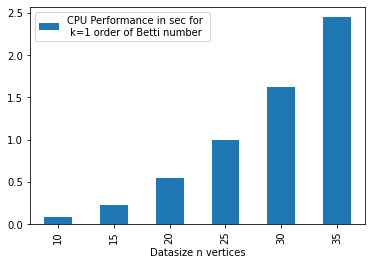

In [ ]:
import time

rows_list = []

my_tuple = [10, 15, 20, 25, 30, 35]

for num in my_tuple:
    st = time.process_time(),
    generate_plots([num], [1]),
    et = time.process_time(),
    performance = [x - y for x, y in zip(list(et), list(st))]
    rows_list.append(performance)

df = pd.DataFrame(rows_list, index=[*(my_tuple)], columns=['CPU Performance in sec for \n k=1 order of Betti number'])
df['Growth'] = df.diff()
print(df)
df = df.reset_index().rename(columns={"index": "Datasize n vertices"})
df.plot(x ='Datasize n vertices', y='CPU Performance in sec for \n k=1 order of Betti number', kind = 'bar')

(k, n, sample) = (2, 10, 0)
(k, n, sample) = (2, 10, 1)
(k, n, sample) = (2, 10, 2)
(k, n, sample) = (2, 10, 3)
(k, n, sample) = (2, 10, 4)
(k, n, sample) = (2, 10, 5)
(k, n, sample) = (2, 10, 6)
(k, n, sample) = (2, 10, 7)
(k, n, sample) = (2, 10, 8)
(k, n, sample) = (2, 10, 9)
(k, n, sample) = (2, 10, 10)
(k, n, sample) = (2, 10, 11)
(k, n, sample) = (2, 10, 12)
(k, n, sample) = (2, 10, 13)
(k, n, sample) = (2, 10, 14)
(k, n, sample) = (2, 10, 15)
(k, n, sample) = (2, 10, 16)
(k, n, sample) = (2, 10, 17)
(k, n, sample) = (2, 10, 18)
(k, n, sample) = (2, 10, 19)
(k, n, sample) = (2, 10, 20)
(k, n, sample) = (2, 10, 21)
(k, n, sample) = (2, 10, 22)
(k, n, sample) = (2, 10, 23)
(k, n, sample) = (2, 10, 24)
(k, n, sample) = (2, 10, 25)
(k, n, sample) = (2, 10, 26)
(k, n, sample) = (2, 10, 27)
(k, n, sample) = (2, 10, 28)
(k, n, sample) = (2, 10, 29)
(k, n, sample) = (2, 10, 30)
(k, n, sample) = (2, 10, 31)
(k, n, sample) = (2, 10, 32)
(k, n, sample) = (2, 10, 33)
(k, n, sample) = (2, 10,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in cdouble_scalars
/usr/lib/python3.7/statistics.py:535: RuntimeWarning: invalid value encountered in double_scalars
  T, total, count = _sum((x-c)**2 for x in data)
/usr/lib/python3.7/statistics.py:538: RuntimeWarning: invalid value encountered in double_scalars
  U, total2, count2 = _sum((x-c) for x in data)


(k, n, sample) = (2, 15, 7)
(k, n, sample) = (2, 15, 8)
(k, n, sample) = (2, 15, 9)
(k, n, sample) = (2, 15, 10)
(k, n, sample) = (2, 15, 11)
(k, n, sample) = (2, 15, 12)
(k, n, sample) = (2, 15, 13)
(k, n, sample) = (2, 15, 14)
(k, n, sample) = (2, 15, 15)
(k, n, sample) = (2, 15, 16)
(k, n, sample) = (2, 15, 17)
(k, n, sample) = (2, 15, 18)
(k, n, sample) = (2, 15, 19)
(k, n, sample) = (2, 15, 20)
(k, n, sample) = (2, 15, 21)
(k, n, sample) = (2, 15, 22)
(k, n, sample) = (2, 15, 23)
(k, n, sample) = (2, 15, 24)
(k, n, sample) = (2, 15, 25)
(k, n, sample) = (2, 15, 26)
(k, n, sample) = (2, 15, 27)
(k, n, sample) = (2, 15, 28)
(k, n, sample) = (2, 15, 29)
(k, n, sample) = (2, 15, 30)
(k, n, sample) = (2, 15, 31)
(k, n, sample) = (2, 15, 32)
(k, n, sample) = (2, 15, 33)
(k, n, sample) = (2, 15, 34)
(k, n, sample) = (2, 15, 35)
(k, n, sample) = (2, 15, 36)
(k, n, sample) = (2, 15, 37)
(k, n, sample) = (2, 15, 38)
(k, n, sample) = (2, 15, 39)
(k, n, sample) = (2, 15, 40)
(k, n, sample) = 

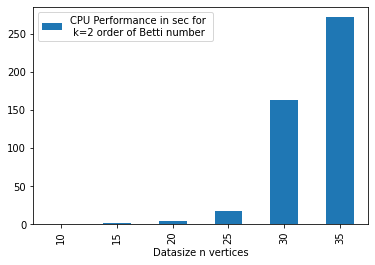

In [ ]:
import time

rows_list = []

my_tuple = [10, 15, 20, 25, 30, 35]

for num in my_tuple:
    st = time.process_time(),
    generate_plots([num], [2]),
    et = time.process_time(),
    performance = [x - y for x, y in zip(list(et), list(st))]
    rows_list.append(performance)

df = pd.DataFrame(rows_list, index=[*(my_tuple)], columns=['CPU Performance in sec for \n k=2 order of Betti number'])
df['Growth'] = df.diff()
print(df)
df = df.reset_index().rename(columns={"index": "Datasize n vertices"})
df.plot(x ='Datasize n vertices', y='CPU Performance in sec for \n k=2 order of Betti number', kind = 'bar')

In [ ]:
# Simple double check
%time generate_plots([25], [1])

(k, n, sample) = (1, 25, 0)
(k, n, sample) = (1, 25, 1)
(k, n, sample) = (1, 25, 2)
(k, n, sample) = (1, 25, 3)
(k, n, sample) = (1, 25, 4)
(k, n, sample) = (1, 25, 5)
(k, n, sample) = (1, 25, 6)
(k, n, sample) = (1, 25, 7)
(k, n, sample) = (1, 25, 8)
(k, n, sample) = (1, 25, 9)
(k, n, sample) = (1, 25, 10)
(k, n, sample) = (1, 25, 11)
(k, n, sample) = (1, 25, 12)
(k, n, sample) = (1, 25, 13)
(k, n, sample) = (1, 25, 14)
(k, n, sample) = (1, 25, 15)
(k, n, sample) = (1, 25, 16)
(k, n, sample) = (1, 25, 17)
(k, n, sample) = (1, 25, 18)
(k, n, sample) = (1, 25, 19)
(k, n, sample) = (1, 25, 20)
(k, n, sample) = (1, 25, 21)
(k, n, sample) = (1, 25, 22)
(k, n, sample) = (1, 25, 23)
(k, n, sample) = (1, 25, 24)
(k, n, sample) = (1, 25, 25)
(k, n, sample) = (1, 25, 26)
(k, n, sample) = (1, 25, 27)
(k, n, sample) = (1, 25, 28)
(k, n, sample) = (1, 25, 29)
(k, n, sample) = (1, 25, 30)
(k, n, sample) = (1, 25, 31)
(k, n, sample) = (1, 25, 32)
(k, n, sample) = (1, 25, 33)
(k, n, sample) = (1, 25,